In [1]:
import numpy as np
from numpy import random
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
from tensorflow.keras import layers
from tensorflow.keras.losses import mse
import seaborn as sns

In [2]:
class Sampling(layers.Layer):
    """Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

In [3]:
latent_dim = 2

encoder_inputs = keras.Input(shape=(2, 1,1))
x = layers.Dense(10, activation="relu")(encoder_inputs)
x = layers.Flatten()(x)
x = layers.Dense(5, activation="relu")(x)
z_mean = layers.Dense(latent_dim, name="z_mean")(x)
z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
z = Sampling()([z_mean, z_log_var])
encoder = keras.Model(encoder_inputs, [z_mean, z_log_var, z], name="encoder")
encoder.summary()

Model: "encoder"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 2, 1, 1)]    0                                            
__________________________________________________________________________________________________
dense (Dense)                   (None, 2, 1, 10)     20          input_1[0][0]                    
__________________________________________________________________________________________________
flatten (Flatten)               (None, 20)           0           dense[0][0]                      
__________________________________________________________________________________________________
dense_1 (Dense)                 (None, 5)            105         flatten[0][0]                    
____________________________________________________________________________________________

In [4]:
latent_inputs = keras.Input(shape=(latent_dim,))
x = layers.Dense(10, activation="relu")(latent_inputs)
x = layers.Dense(2, activation="relu")(x)
decoder_outputs = layers.Reshape((2, 1,1))(x)
decoder = keras.Model(latent_inputs, decoder_outputs, name="decoder")
decoder.summary()

Model: "decoder"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 2)]               0         
_________________________________________________________________
dense_2 (Dense)              (None, 10)                30        
_________________________________________________________________
dense_3 (Dense)              (None, 2)                 22        
_________________________________________________________________
reshape (Reshape)            (None, 2, 1, 1)           0         
Total params: 52
Trainable params: 52
Non-trainable params: 0
_________________________________________________________________


In [5]:
class VAE(keras.Model):
    def __init__(self, encoder, decoder, **kwargs):
        super(VAE, self).__init__(**kwargs)
        self.encoder = encoder
        self.decoder = decoder

    def train_step(self, data):
        if isinstance(data, tuple):
            data = data[0]
        with tf.GradientTape() as tape:
            z_mean, z_log_var, z = encoder(data)
            reconstruction = decoder(z)
            reconstruction_loss = tf.reduce_mean(
                mse(data, reconstruction)
            )
            reconstruction_loss *= 2
            kl_loss = 1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)
            kl_loss = tf.reduce_mean(kl_loss)
            kl_loss *= -0.5
            total_loss = reconstruction_loss + kl_loss
        grads = tape.gradient(total_loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
        return {
            "loss": total_loss,
            "reconstruction_loss": reconstruction_loss,
            "kl_loss": kl_loss,
        }

In [6]:
def gen_data(ind,length):
    random.seed(50)
    indid = np.random.choice(ind,length)
   
    indfe = np.random.normal(size=ind)+10

    w = indfe[indid] + 0.1*np.random.normal(size=length)
    data = np.transpose(np.array([w,indid]))
    return {'data':data, 'indfe':indfe}

In [7]:
rs=gen_data(100,10000)

In [8]:
data=rs['data']


In [9]:


vae = VAE(encoder, decoder)
vae.compile(optimizer=keras.optimizers.Adam())
vae.fit(data.reshape((data.shape[0],2,1,1)), epochs=150, batch_size=128)

Epoch 1/150
79/79 [==============================] - 0s 2ms/step - loss: 3828.9180 - reconstruction_loss: 3300.3154 - kl_loss: 528.6025
Epoch 2/150
79/79 [==============================] - 0s 1ms/step - loss: 2680.6244 - reconstruction_loss: 2473.8518 - kl_loss: 206.7726
Epoch 3/150
79/79 [==============================] - 0s 1ms/step - loss: 2193.1361 - reconstruction_loss: 1984.1952 - kl_loss: 208.9409
Epoch 4/150
79/79 [==============================] - 0s 2ms/step - loss: 1606.9376 - reconstruction_loss: 1421.7916 - kl_loss: 185.1460
Epoch 5/150
79/79 [==============================] - 0s 2ms/step - loss: 852.3466 - reconstruction_loss: 687.1666 - kl_loss: 165.1800
Epoch 6/150
79/79 [==============================] - 0s 2ms/step - loss: 370.7786 - reconstruction_loss: 203.9115 - kl_loss: 166.8671
Epoch 7/150
79/79 [==============================] - 0s 2ms/step - loss: 261.3454 - reconstruction_loss: 106.1323 - kl_loss: 155.2130
Epoch 8/150
79/79 [==============================] - 0

In [10]:
est = decoder.predict(encoder(data.reshape((data.shape[0],2,1,1)))).reshape(data.shape[0],2)[:,0]
real=rs['data'][:,0]

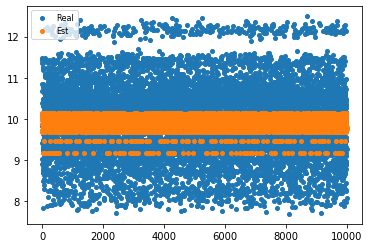

In [11]:
fig,ax=plt.subplots()
label=[]
ax.plot(real,'o',markersize=4)
label=label+['Real']
ax.plot(est,'o',markersize=4)
label=label+['Est']
plt.legend(label,fontsize=8)


In [24]:
est_ind=encoder(data.reshape((data.shape[0],2,1,1)))[2].numpy()[:,0]
real_ind=rs['indfe'][rs['data'][:,1].astype(int)]

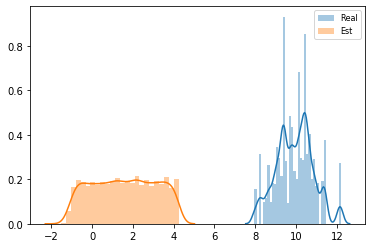

In [25]:
label=[]
sns.distplot(real_ind)
label=label+['Real']
sns.distplot(est_ind)
label=label+['Est']
plt.legend(label,fontsize=8)

In [26]:
est_eps=encoder(data.reshape((data.shape[0],2,1,1)))[2].numpy()[:,1]


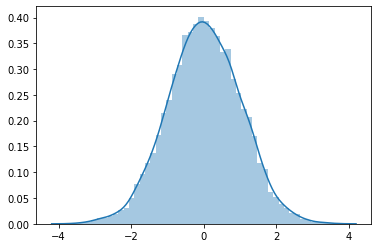

In [27]:
label=[]
sns.distplot(est_eps)

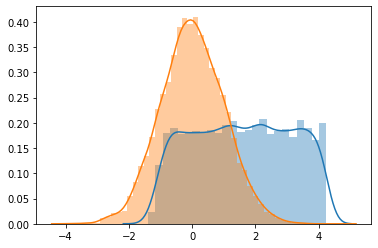

In [28]:
sns.distplot(encoder(data.reshape((data.shape[0],2,1,1)))[2].numpy()[:,0])
sns.distplot(encoder(data.reshape((data.shape[0],2,1,1)))[2].numpy()[:,1])



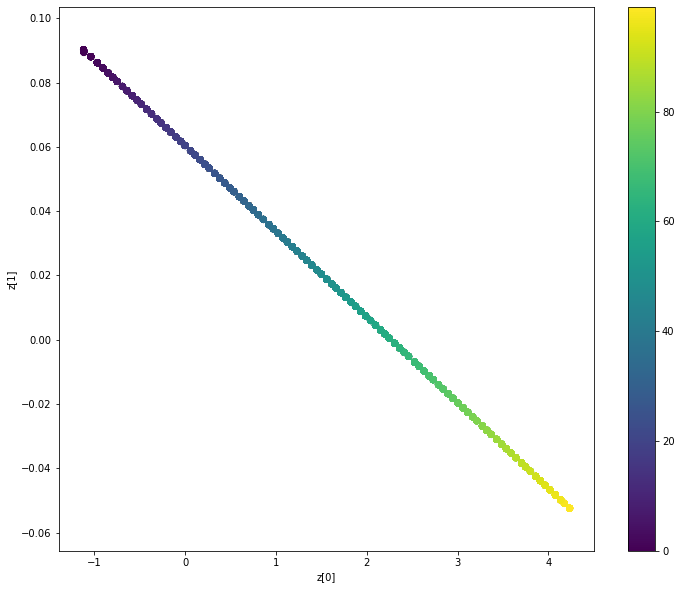

In [22]:
z_mean, _, _ = encoder.predict(data.reshape((data.shape[0],2,1,1)))
plt.figure(figsize=(12, 10))
labels=rs['data'][:,1].astype(int)
plt.scatter(z_mean[:, 0], z_mean[:, 1], c=labels)
plt.colorbar()
plt.xlabel("z[0]")
plt.ylabel("z[1]")
plt.show()




In [23]:
z_mean

array([[ 1.4992098 ,  0.02044128],
       [ 4.0778437 , -0.04824533],
       [-0.4829036 ,  0.07323846],
       ...,
       [ 3.5863614 , -0.03515379],
       [ 3.643804  , -0.03668389],
       [ 3.2106543 , -0.02514616]], dtype=float32)